<span style='font-size: 2.5em'><b>Implementing a Linear Classifier from Scratch </b></span><br/>

<span style='font-size: 1.5em'>Wine recognition dataset</span>

<span style="background-color: #ffc351; padding: 4px; font-size: 1em;"><b>Final Sprint </b></span>



### **D3APL – Aplicações em Ciência de Dados** (IFSP, Campinas) <br/>
**Prof**: Samuel Martins (Samuka) <br/>

#### Study Project

**Students**: Carlos Danilo Tomé e Lucas Galdino de Camargo

**Dataset**: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html

**Final Goal**: Predict housing prices for sale in São Paulo using machile learning models and techniques.

---

## 🎯 Notebook Goals

- 0. Imports, settings and data reading
- 1. Framing the problem
- 2. EDA and Data Cleanning
- 3. Modelling
- 4. Results

---

### 0. Imports, settings and read data

In [74]:
import sklearn
from sklearn.datasets import load_wine
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils import check_X_y

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple
import numpy as np
from numpy import ndarray


sns.set_theme(style="whitegrid")

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

import warnings
warnings.filterwarnings("ignore")

In [75]:
data = load_wine(return_X_y=True,as_frame=True)

df = pd.concat([data[0], data[1]], axis=1)

df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


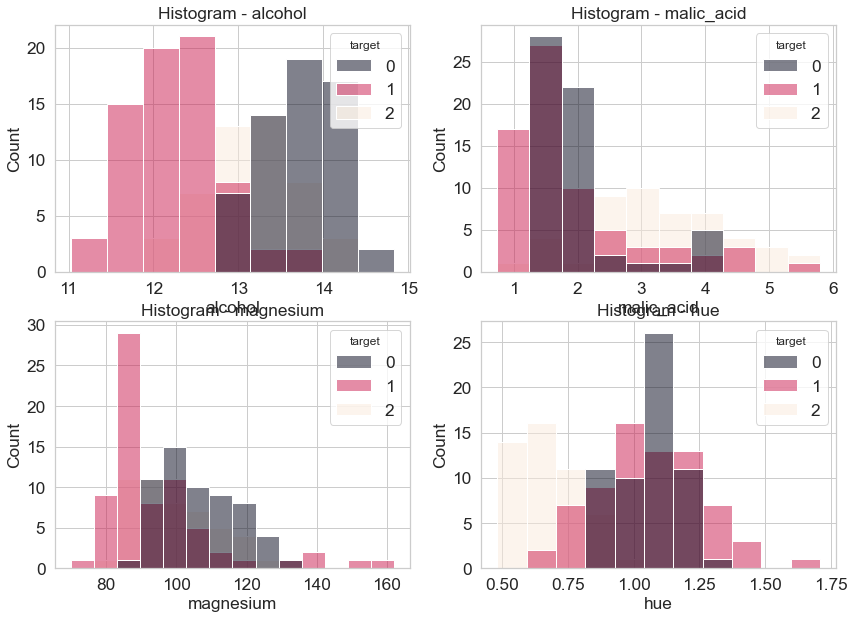

In [76]:
fig, axes = plt.subplots(2, 2, figsize=(14,10))

sns.histplot(x="alcohol", data=df,  ax=axes[0, 0], palette ='rocket' ,hue="target")
axes[0, 0].set_title('Histogram - alcohol')

sns.histplot(x="malic_acid", data=df,  ax=axes[0, 1], palette ='rocket'  ,color = 'tab:orange',hue="target")
axes[0, 1].set_title('Histogram - malic_acid')

sns.histplot(x="magnesium", data=df,  ax=axes[1, 0], palette ='rocket'  ,color = 'tab:blue',hue="target")
axes[1, 0].set_title('Histogram - magnesium')

sns.histplot(x="hue", data=df,  ax=axes[1, 1], palette ='rocket' ,color = 'tab:orange',hue="target")
axes[1, 1].set_title('Histogram - hue');

In [ ]:
class LogisticRegression(ClassifierMixin, BaseEstimator):
    """Our Logistic Regression implemented from scratch."""
    
    
    # Define alguns parametros iniciais e inicializa a classe
    # 
    def __init__(self, learning_rate : float = 0.001, n_epochs : int = 1000, random_state : int = 42):

        """
        Parameters
        ----------
        learning_rate : float, default=0.001
            Learning rate.
        n_epochs : int, default=1000
            Number of epochs for training (convergence stop).
        random_state : int, default=42
            Seed used for generating random numbers.
        """
        assert (learning_rate is not None) and (learning_rate > 0.0), \
        f'Learning rate must be > 0. Passed: {learning_rate}'

        assert (n_epochs is not None) and n_epochs > 0, \
        f'Number of epochs must be > 0. Passed: {n_epochs}'

        assert (random_state is not None) and random_state >= 0, \
        f'Random state should be >= 0. Passed: {random_state}'

        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.random_state = random_state

        # model / parameters - private
        self.__w = None
        # bias
        self.__b = None


        # a special method used to represent a class object as a string, called with print() or str()
    def __str__(self):

        msg = f'Learning Rate: {self.learning_rate}\n' \
              f'Number of Epochs: {self.n_epochs}\n' \
              f'Random state (seed): {self.random_state}\n\n' \
              f'Trained?: {self.is_fitted()}\n'
        return msg
        
    def is_fitted(self) -> bool:
        """Check if the estimator is fitted by verifying the presence of a (learned) weight matrix"""
        return self.__w is not None

    
    # getter: access the function as an attribute
    @property
    def coef_(self) -> ndarray:
        """Return the weight matrix (learned parameters) if the estimator was fitted/trained.
           Otherwise, raise an exception.
        """
        assert self.is_fitted(), 'The instance is not fitted yet.'
        return self.__w
    
    # getter: access the function as an attribute
    @property
    def intercept_(self) -> float:
        """Return the bias (learned intercepet) if the estimator was fitted/trained.
           Otherwise, raise an exception.
        """
        assert self.is_fitted(), 'The instance is not fitted yet.'
        return self.__b
    
    
    def __sigmoid(self, z: float) -> float:
        return 1 / (1 + np.e ** (-z))    
    
    
    def __log_loss(self, y: ndarray, p_hat: ndarray, eps: float = 1e-15):
        """Return the log loss for a given estimation and ground-truth (true labels).
        
        Since log loss is undefined for `p=0` and `p=1`, we clipped the probabilities to max(eps, min(1 - eps, p)).
        
        Parameters
        ----------
        y : ndarray, shape (n_samples,)
            True labels of input samples.
        p_hat : ndarray
            Estimated probabilities of input samples.
        eps : float, default=1e-15
            Epsilon term used to avoid undefined log loss at 0 and 1.
        
        Returns
        -------
        log_loss : float
            Computed log loss.
        """
        p_hat_eps = np.maximum(eps, np.minimum(1 - eps, p_hat))
        
        losses = -(y * np.log(p_hat_eps) + (1 - y) * np.log(1 - p_hat_eps))
        log_loss = losses.mean()

        return log_loss

    def __gradient(self, X: ndarray, y: ndarray, p_hat: ndarray) -> Tuple[ndarray, float]:
        '''Compute the gradient vector for the log loss with regards to the weights and bias.
        
        Parameters
        ----------
        X: ndarray of shape (n_samples, n_features)
            Training data.
        y: ndarray of shape (n_samples,).
            Target (true) labels.
        p_hat : ndarray, shape (n_samples,)
            Estimated probabilities.
        
        Returns
        -------
        Tuple[ndarray, float]: 
            Tuple with:
            - a numpy array of shape (n_features,) containing the partial derivatives w.r.t. the weights; and
            - a float representing the partial derivative w.r.t. the bias.
        '''
        # X.shape ==> (n_samples, n_features)
        # y.shape ==> (n_samples,)
        n_samples = X.shape[0]
        
        error = p_hat - y  # shape (n_samples,)
        
        grad_w = np.dot(error, X) / n_samples  # shape (n_features,)
        
        # as x_0 will be array 1.0 (bias trick), the gradient for the bias is simplified
        grad_b = np.sum(error) / n_samples  # scalar
        
        return grad_w, grad_b



    def fit(self, X: ndarray, y: ndarray, verbose: int = 0):
        '''Train a Logistic Regression classifier.

        Parameters
        ----------
        X: ndarray of shape (n_samples, n_features)
            Training data.
        y: ndarray of shape (n_samples,).
            Target (true) labels.
        verbose: int, default=0
            Verbose flag. Print training information every `verbose` iterations.
            
        Returns
        -------
        self : object
            Returns self.
        '''
        ### CHECK INPUT ARRAY DIMENSIONS
        assert X.ndim == 2, f'X must be 2D. Passed: {X.ndim}'
        assert y.ndim == 1, f'y must be 1D. Passed: {y.ndim}'
        assert X.shape[0] == y.shape[0], \
            f'X.shape[0] should be equal to y.shape[0], instead: {X.shape[0]} != {y.shape[0]}'
        # X, y = check_X_y(X, y)

        ### SETTING SEED
        np.random.seed(self.random_state)
        
        n_samples, n_features = X.shape

        # Altough the bias trick is an elegant solution to merge all
        # parameters, it requires to extend the feature matrix X
        # by adding one column of 1.0. This demands time, so we will
        # deal with the weights and bias separately.

        ### PARAMETER INITIALIZATION
        
        # return values from the “standard normal” distribution.
        w = np.random.randn(n_features)
        b = 0.0

        losses = []

        # learning iterations
        for epoch in np.arange(self.n_epochs):
            ### ESTIMATION (FORWARD PASS)
            # X.shape == (n_samples, n_features)
            # w.shape = (n_features,)
            # p_hat = (n_samples,)
            z = np.dot(X, w) + b
            p_hat = self.__sigmoid(z)
            
            loss = self.__log_loss(y, p_hat)
            losses.append(loss)
            
            ### GRADIENT DESCENT (BACKWARD PASS)
            # grad_w.shape ==> (n_samples, 1)
            # grad_b: scalar
            grad_w, grad_b = self.__gradient(X, y, p_hat)
            w = w - self.learning_rate * grad_w
            b = b - self.learning_rate * grad_b
            
            # check to see if an update should be displayed
            if verbose and (epoch == 0 or (epoch + 1) % verbose == 0):
                print(f'[INFO] epoch={epoch + 1}/{self.n_epochs}, loss={loss:.7f}')
        
        if verbose > 0:
            losses = np.array(losses)
            print(f'\nFinal loss: {loss}')
            print(f'\nMean loss: {losses.mean()} +- {losses.std()}')
            
        ### ASSIGN THE TRAINED PARAMETERS TO THE PRIVATE ATTRIBUTES
        self.__w = w
        self.__b = b
        
    
    
    def predict_proba(self, X: ndarray) -> ndarray:
        '''Estimate the probability for the positive class of input samples.

        Parameters
        ----------
        X: ndarray of shape (n_samples, n_features)
            Input samples.
            
        Returns
        -------
        ndarray of shape (n_samples,)
            The estimated probabilities for the positive class of input samples.
        '''
        assert self.is_fitted(), 'The instance is not fitted yet.'
        assert X.ndim == 2, f'X must be 2D. Passed: {X.ndim}'
        
        z = np.dot(X, self.__w) + self.__b

        return self.__sigmoid(z)

    
    def predict(self, X: ndarray) -> ndarray:
        '''Predict the labels for input samples.
        
        Thresholding at probability >= 0.5.

        Parameters
        ----------
        X: ndarray of shape (n_samples, n_features)
            Input samples.
            
        Returns
        -------
        ndarray of shape (n_samples,)
            Predicted labels of input samples.
        '''
        assert self.is_fitted(), 'The instance is not fitted yet.'
        assert X.ndim == 2, f'X must be 2D. Passed: {X.ndim}'

        p_hat = self.predict_proba(X)
        y_hat = p_hat >= 0.5  # ndarray of bools
        y_hat = y_hat.astype(np.int)
        
        return y_hat